# NWA suntans: mean and low pass filtering

see [description](https://github.com/TIDE-ITRH/tide-suntans-nws) and relevant paper: [Rayson et al. 2021](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/2021JC017570)

Need: depth, cell manipulations


In [1]:
import os

import numpy as np
import pandas as pd
import xarray as xr

%matplotlib inline
from matplotlib import pyplot as plt

from oceans.filters import lanc

import pynsitu as pin
crs = pin.maps.crs

import nwatools as nwa

ERROR 1: PROJ: proj_create_from_database: Open of /home1/datahome/aponte/.miniconda3/envs/equinox/share/proj failed


In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    #cluster = PBSCluster(cores=28, processes=14)
    #cluster = PBSCluster(cores=14, processes=7)
    w = cluster.scale(jobs=2)
    #
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

---
## load data

In [3]:
store = True

In [5]:
ds, grd = nwa.load_surf()

# add squared variables
ds["eta2"] = ds.eta**2
ds["temp2"] = ds.temp**2
# kinetic energy
ds["uc2"] = ds.uc**2
ds["vc2"] = ds.vc**2
ds["ke"] = 0.5*(ds.uc**2+ds.vc**2)

ds = ds.persist()

In [6]:
ds

<xarray.Dataset>
Dimensions:  (Nc: 225368, numsides: 8, Nk: 80, time: 8772, Np: 454016)
Coordinates:
    cells    (Nc, numsides) int32 dask.array<chunksize=(2000, 8), meta=np.ndarray>
    dv       (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    dz       (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
    nfaces   (Nc) int32 dask.array<chunksize=(2000,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2013-07-01T00:01:00 ... 2014-07-01
    xp       (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    xv       (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    yp       (Np) float64 dask.array<chunksize=(454016,), meta=np.ndarray>
    yv       (Nc) float64 dask.array<chunksize=(2000,), meta=np.ndarray>
    z_r      (Nk) float64 dask.array<chunksize=(80,), meta=np.ndarray>
Dimensions without coordinates: Nc, numsides, Nk, Np
Data variables:
    eta      (time, Nc) float64 dask.array<chunksize=(745, 2000), meta=np.ndarray>
    temp     (time, Nc) float64 dask.array<chunksize=(745, 2000), meta=np.ndarray>
    uc       (time, Nc) float64 dask.array<chunksize=(745, 2000), meta=np.ndarray>
    vc       (time, Nc) float64 dask.array<chunksize=(745, 2000), meta=np.ndarray>
    eta2     (time, Nc) float64 dask.array<chunksize=(745, 2000), meta=np.ndarray>
    temp2    (time, Nc) float64 dask.array<chunksize=(745, 2000), meta=np.ndarray>
    uc2      (time, Nc) float64 dask.array<chunksize=(745, 2000), meta=np.ndarray>
    vc2      (time, Nc) float64 dask.array<chunksize=(745, 2000), meta=np.ndarray>
    ke       (time, Nc) float64 dask.array<chunksize=(745, 2000), meta=np.ndarray>
Attributes:
    Author:       mrayson
    Description:  SUNTANS surface fields

### compute temporally averaged fields

In [7]:
dsm = ds.mean("time")
dsm["mke"] = 0.5*(dsm.uc**2+dsm.vc**2)
dsm = dsm.compute() # fits in memory

# weird bug under investigation, quick fix:
#dsm = dsm.chunk()

In [8]:
if store:
    zarr = os.path.join(nwa.suntans_dir, "suntans_2km_surf_mean")
    dsm.to_zarr(zarr, mode="w")

In [9]:
# just show grid points
#fig, ax, _ = pin.maps.plot_map(**mapkw)
#ax.scatter(ds.xp, ds.yp, s=1, c="k", transform=crs)

Changing the _FillValue from -999999 to 999999


/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


Text(0.5, 1.0, 'mean kinetic energy')

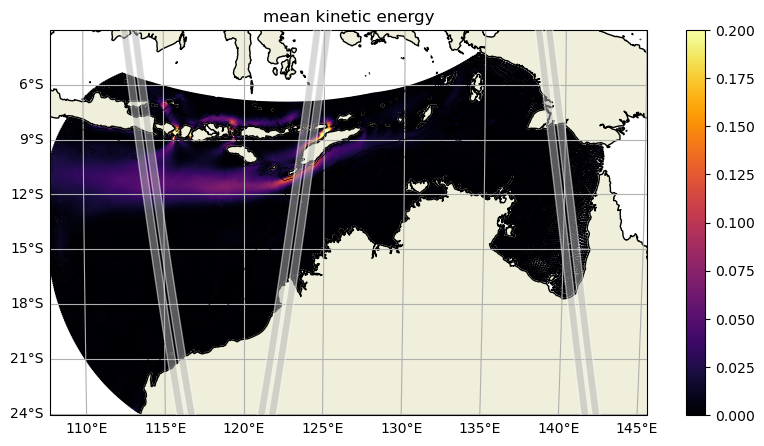

In [10]:
_ds = dsm

fig, ax = nwa.map_init("very_large", bathy=(grd, ds), bathy_kw = dict(colors="w"))

hdl = ax.scatter(_ds.xv, _ds.yv, s=1, c=_ds.mke, transform=crs, vmax=.2, cmap="inferno")
fig.colorbar(hdl)
ax.set_title("mean kinetic energy")

Text(0.5, 1.0, 'mean kinetic energy')

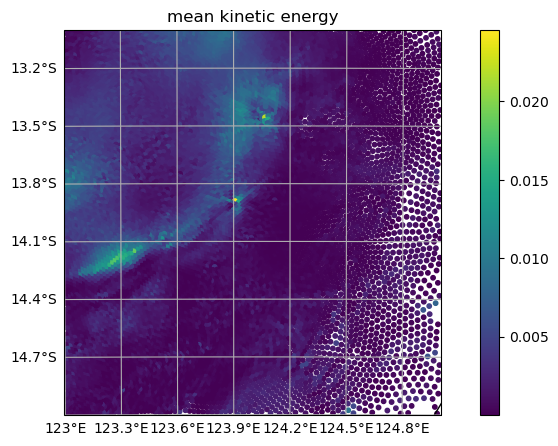

In [11]:
_ds = nwa.zoom(dsm, nwa.area_cp)

fig, ax, _ = pin.maps.plot_map(**mapkw)
hdl = ax.scatter(_ds.xv, _ds.yv, s=10, c=_ds.mke, transform=crs)
fig.colorbar(hdl)
ax.set_title("mean kinetic energy")

Text(0.5, 1.0, 'total kinetic energy')

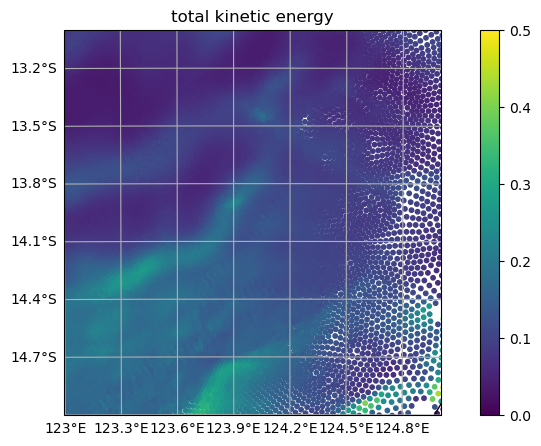

In [14]:
_ds = dsm

fig, ax, _ = pin.maps.plot_map(**mapkw)
hdl = ax.scatter(_ds.xv, _ds.yv, s=10, c=_ds.ke, transform=crs, vmax=.5)
fig.colorbar(hdl)
ax.set_title("total kinetic energy")

---

## apply rolling window to kill tidal variability

#### rolling means - old

In [20]:
def low_pass(Nlow):
    return (ds.rolling(time=Nlow, center=True)
           .mean()
           .chunk(dict(time=745))
           .persist()
    )

In [21]:
#Nlow = 25
Nlow = 49
dsr = low_pass(Nlow)

zarr = os.path.join(nwa.suntans_dir, f"suntans_2km_surf_lowp{Nlow}")
dsr.to_zarr(zarr, mode="w")

In [24]:
del dsr

#### with lanczos filter

In [4]:
w_lanczos40 = lanc(96 + 1 + 96, 1.0 / 40)
weights = xr.DataArray(w_lanczos40, dims=["window"])

In [ ]:
# apply to time series

#ds = ds.isel(Nc=slice(0,100))
dsr = xr.merge([ds[v]
       .rolling(time=w_lanczos40.size, center=True)
       .construct(time="window")
       .dot(weights)
       .chunk(dict(time=745))
       .rename(v)
       .persist()
            for v in ["eta", "temp", "uc", "vc", "ke"]
]
)

In [19]:
zarr = os.path.join(nwa.suntans_dir, f"suntans_2km_surf_low")
dsr.to_zarr(zarr, mode="w")

#### compare frequency responses

In [5]:
filters = dict(H25=np.ones(25)/25,
               H36=np.ones(36)/36,
               H49=np.ones(49)/49,
               lanczos40=w_lanczos40,
              )

In [17]:
H = dict()
for f, w in filters.items():
    H[f], omega = pin.tseries.filter_response(w, dt=1/24)

In [13]:
# 
omega_inertial = {lat: pin.geo.coriolis(lat)*86400/2/np.pi for lat in [-12, -15, -18]}

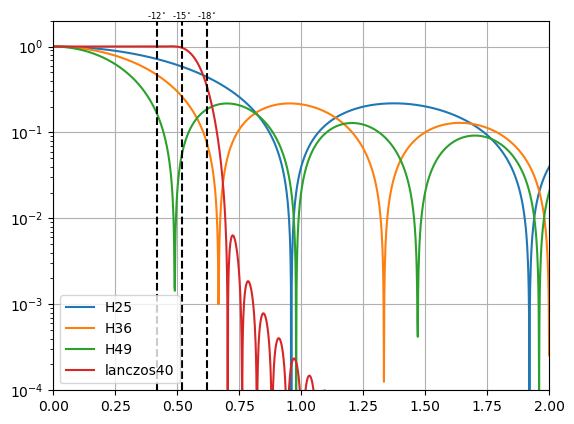

In [28]:
fig, ax = plt.subplots(1,1)
for f, h in H.items():
    ax.plot(omega, np.abs(h), label=f)
ax.set_yscale("log")
#ax.set_xscale("log")
ax.grid()
ax.legend()
ax.set_xlim(0, 2)
ax.set_ylim(1e-4, 2)
for lat, _omega in omega_inertial.items():
    ax.axvline(abs(_omega), color="k", ls="--")
    ax.text(abs(_omega), 2.1, str(lat)+r"$^\circ$", size=6, ha="center")

## reload and compute low frequency temporal average (mostly for energies)

In [11]:
zarr = os.path.join(nwa.suntans_dir, f"suntans_2km_surf_low")
ds = xr.open_zarr(zarr)

In [12]:
# add squared variables
ds["eta2"] = ds.eta**2
ds["temp2"] = ds.temp**2
# kinetic energy
ds["uc2"] = ds.uc**2
ds["vc2"] = ds.vc**2
ds["ke"] = 0.5*(ds.uc**2+ds.vc**2)

In [13]:
dsm = ds.mean("time")
dsm["mke"] = 0.5*(dsm.uc**2+dsm.vc**2)
dsm = dsm.compute() # fits in memory

# weird bug under investigation, quick fix:
#dsm = dsm.chunk()

In [14]:
if store:
    zarr = os.path.join(nwa.suntans_dir, "suntans_2km_surf_low_mean")
    dsm.to_zarr(zarr, mode="w")

## reload and compare different filters at one or two locations

In [3]:
ds, grd = nwa.load_surf()

zarr = os.path.join(nwa.suntans_dir, f"suntans_2km_surf_low")
dsl = xr.open_zarr(zarr)

In [4]:
pts = dict(W310 = nwa.moorings["W310"],
           offshore_south = [115, -16],
           offshore_north = [115, -12],
          )

colors = dict(W310="k",
              offshore_south="cadetblue",
              offshore_north="orange",
             )

In [5]:
# find point indexes
def find_idx(p):
    d2 = (p[0] - grd.xv)**2 + (p[1] - grd.yv)**2
    return int(d2.argmin("Nc").compute())
idx = {label: find_idx(p) for label, p in pts.items()}
idx_xr = pd.Series(idx).to_xarray().rename(index="point")

# load data at points of interests
ds_pts = ds.isel(Nc=idx_xr).compute()
dsl_pts = dsl.isel(Nc=idx_xr).compute()

Changing the _FillValue from -999999 to 999999


/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.9/site-packages/geopandas/tools/clip.py:66: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clipped.loc[


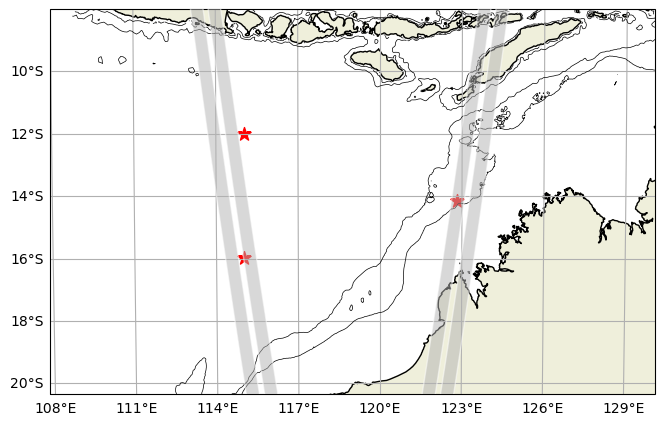

In [6]:
zoom= "large"

fig, ax = nwa.map_init(zoom, bathy=(grd, ds))

for label, i in idx.items():
    ax.scatter(grd.xv[i], grd.yv[i], s=100, marker="*", color="r", transform=crs)

In [17]:
def plot_tseries(tslice=None, raw=True, low=False):

    if tslice is not None:
        ds = ds_pts.sel(time=tslice)
        dsl = dsl_pts.sel(time=tslice)
    else:
        ds = ds_pts
        dsl = dsl_pts
    
    fig, axes = plt.subplots(4,1, figsize=(10,10), sharex=True)

    # sea level
    ax = axes[0]
    i=0
    for p in pts:
        label=p
        if raw:
            (ds.eta+i).sel(point=p).plot(ax=ax, color=colors[p], label=label)
            label=None
        if low:
            dsl.eta.sel(point=p).plot(ax=ax, color=colors[p], label=label)
        i+=1
    ax.grid()
    ax.legend()
    ax.set_title("sea level")
    ax.set_xlabel("")

    # zonal current
    ax = axes[1]
    for p in pts:
        if raw:
            ds.sel(point=p).uc.plot(ax=ax, color=colors[p], label=p)
        if low:
            dsl.sel(point=p).uc.plot(ax=ax, color=colors[p])
    ax.grid()
    ax.set_title("zonal current")
    ax.set_xlabel("")

    # meridional current
    ax = axes[2]
    for p in pts:
        if raw:
            ds.sel(point=p).vc.plot(ax=ax, color=colors[p], label=p)
        if low:
            dsl.sel(point=p).vc.plot(ax=ax, color=colors[p])
    ax.grid()
    ax.set_title("meridional current")
    ax.set_xlabel("")

    # temperature
    ax = axes[3]
    for p in pts:
        if raw:
            ds.sel(point=p).temp.plot(ax=ax, color=colors[p], label=p)
        if low:
            dsl.sel(point=p).temp.plot(ax=ax, color=colors[p])
    ax.grid()
    ax.set_title("temperature")


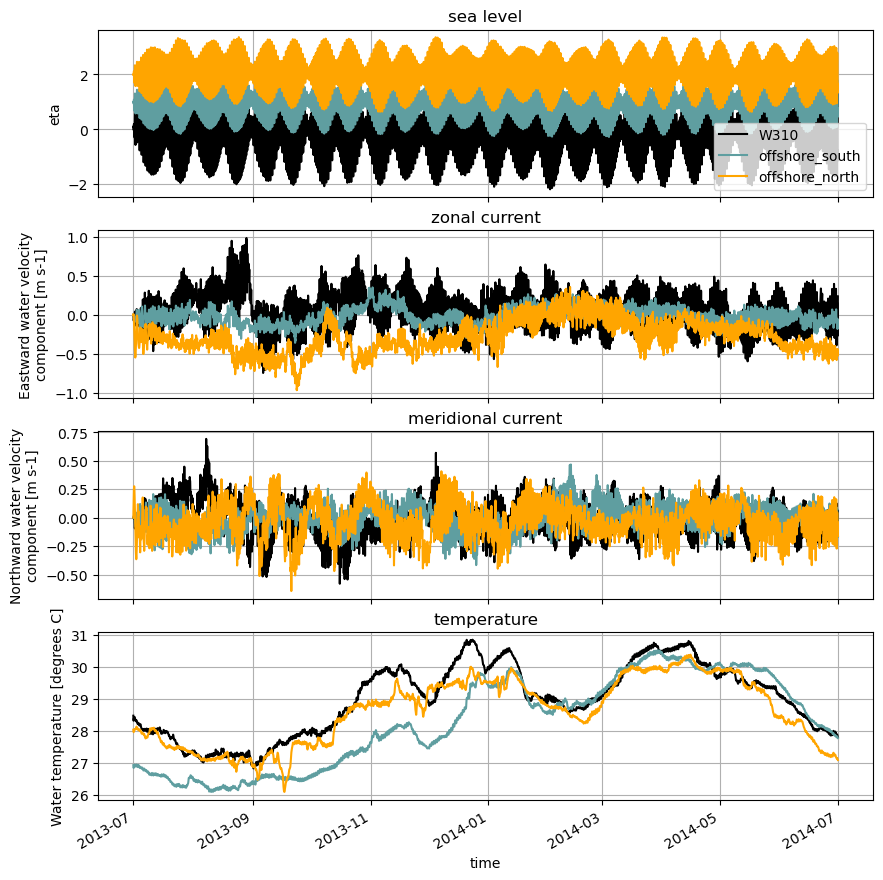

In [18]:
plot_tseries()

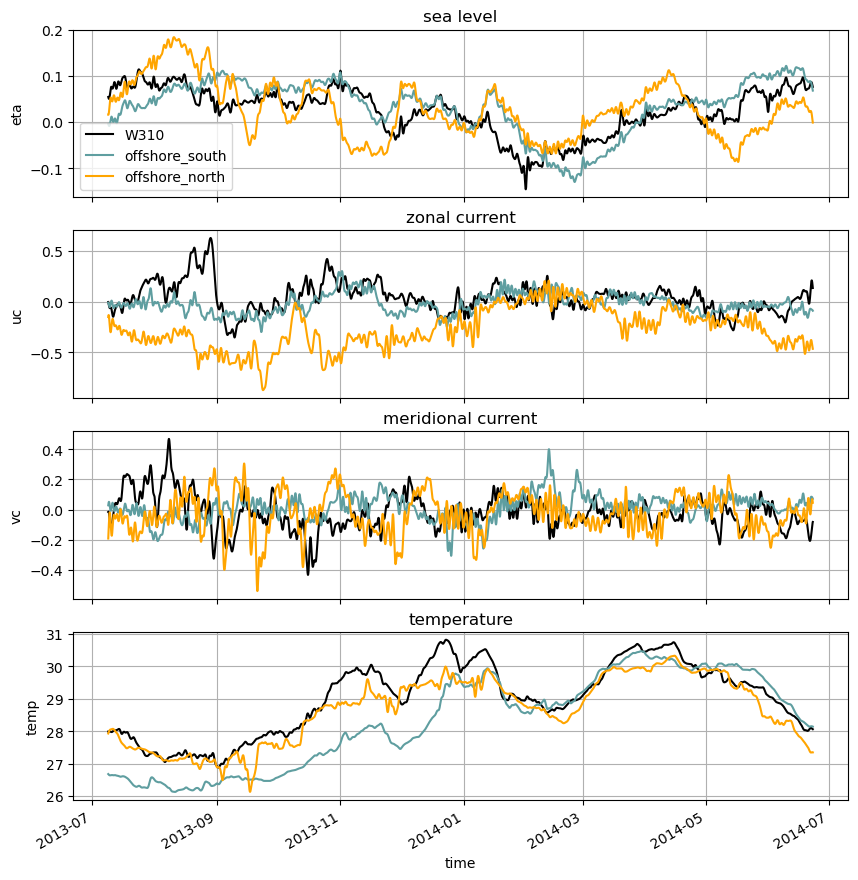

In [19]:
plot_tseries(raw=False, low=True)

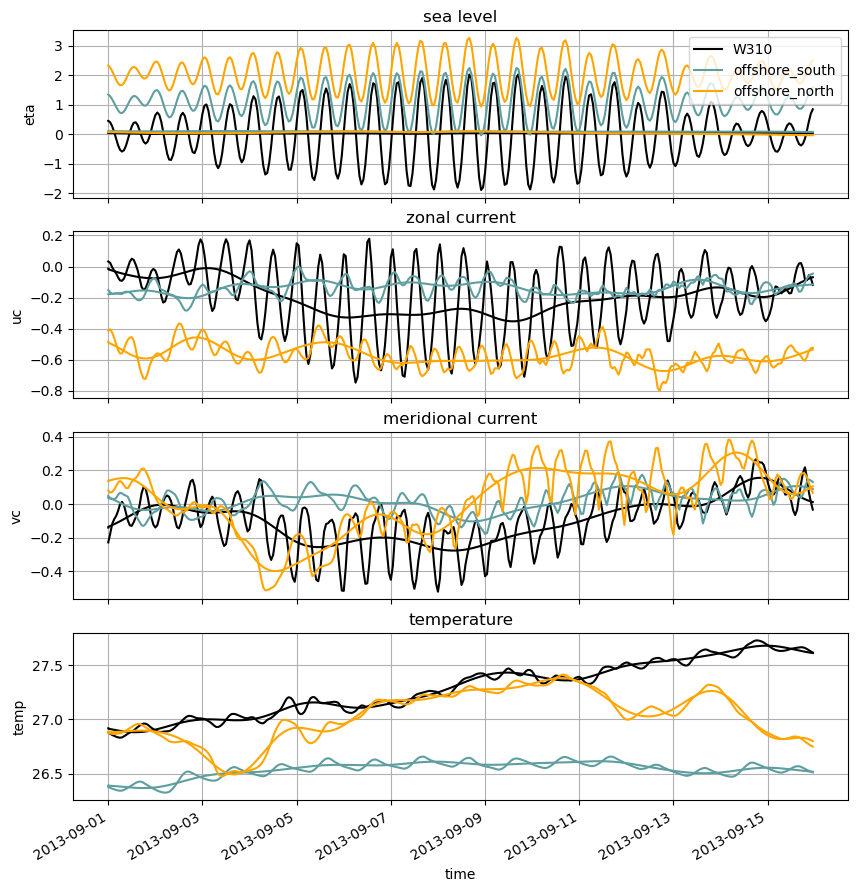

In [21]:
tslice = slice("2013-09", "2013-09-15")
plot_tseries(tslice=tslice, low=True)

## should do spectra next and energy budget decomposition

---
### dev Lanczos

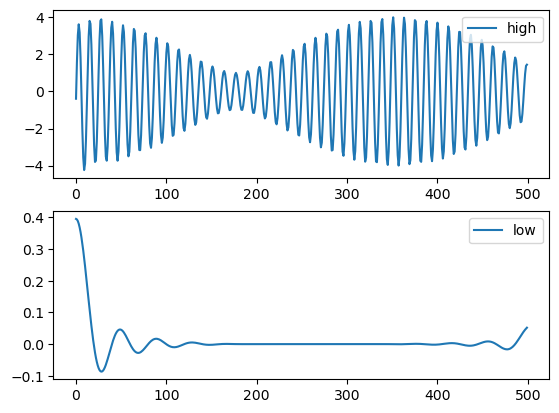

In [23]:
wt = lanc(96 + 1 + 96, 1.0 / 40)

t = np.arange(500)  # Time in hours.
h = 2.5 * np.sin(2 * np.pi * t / 12.42)
h += 1.5 * np.sin(2 * np.pi * t / 12.0)
#h += 0.3 * np.random.randn(len(t))

low = np.convolve(wt, h, mode="same")
high = h - low
fig, (ax0, ax1) = plt.subplots(nrows=2)
_ = ax0.plot(high, label="high")
_ = ax1.plot(low, label="low")
_ = ax0.legend(numpoints=1)
_ = ax1.legend(numpoints=1)

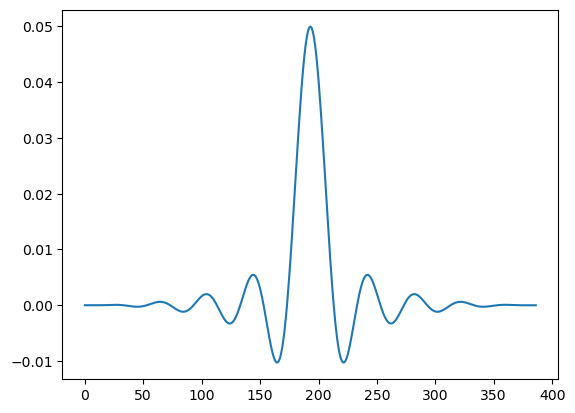

In [24]:
plt.plot(wt)

---

In [15]:
cluster.close()